<a href="https://colab.research.google.com/github/iamBHK/Sports-Image-Classification/blob/main/SportsImagesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import glob
from PIL import ImageFile

from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import Callback, EarlyStopping

In [ ]:
train = 'dataset-original/train'
test = 'dataset-original//test'

In [ ]:
filepaths_train = list(glob.glob(train+'/**/*.jpg'))
filepaths_test = list(glob.glob(test+'/**/*.jpg'))

In [ ]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [ ]:
train_df = proc_img(filepaths_train)
test_df = proc_img(filepaths_test)

In [ ]:
print(f'Number of training pictures: {train_df.shape[0]}')
print(f'Number of test pictures: {test_df.shape[0]}')

Number of training pictures: 13572
Number of test pictures: 500


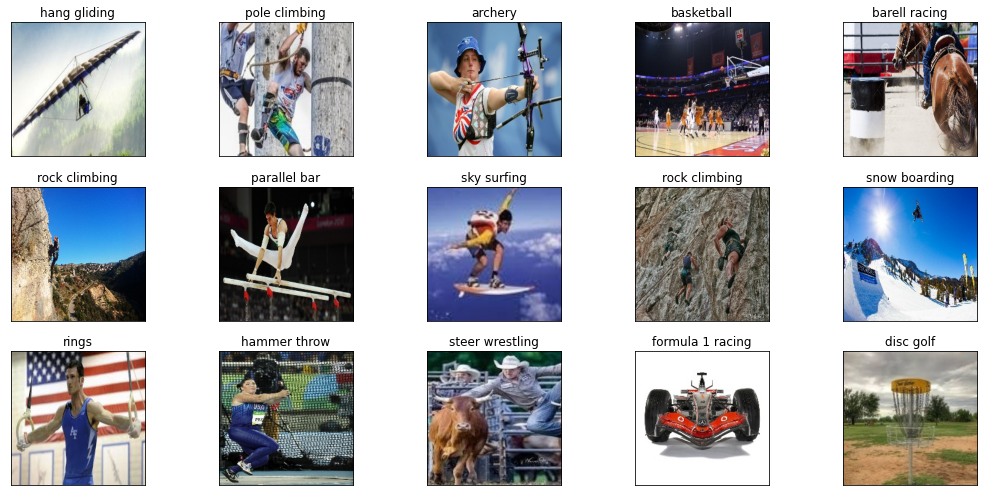

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Label[i])
plt.tight_layout()
plt.show()

In [ ]:
# This code fix an error, which would occur during the training otherwise
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 10858 validated image filenames belonging to 100 classes.
Found 2714 validated image filenames belonging to 100 classes.
Found 500 validated image filenames belonging to 100 classes.


In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(200, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(200, activation='relu')(x)

outputs = tf.keras.layers.Dense(100, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              mode='auto')]

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=6,
    callbacks = my_callbacks
)

Epoch 1/6
340/340 [==============================] - 236s 691ms/step - loss: 1.5844 - accuracy: 0.5985 - val_loss: 0.7897 - val_accuracy: 0.7741
Epoch 2/6
340/340 [==============================] - 243s 715ms/step - loss: 0.4799 - accuracy: 0.8564 - val_loss: 0.6323 - val_accuracy: 0.8172
Epoch 3/6
340/340 [==============================] - 242s 712ms/step - loss: 0.2727 - accuracy: 0.9197 - val_loss: 0.5810 - val_accuracy: 0.8301
Epoch 4/6
340/340 [==============================] - 260s 766ms/step - loss: 0.1597 - accuracy: 0.9528 - val_loss: 0.5491 - val_accuracy: 0.8397
Epoch 5/6
340/340 [==============================] - 254s 749ms/step - loss: 0.0898 - accuracy: 0.9746 - val_loss: 0.6269 - val_accuracy: 0.8357
Epoch 6/6
340/340 [==============================] - 240s 706ms/step - loss: 0.0645 - accuracy: 0.9809 - val_loss: 0.6360 - val_accuracy: 0.8368


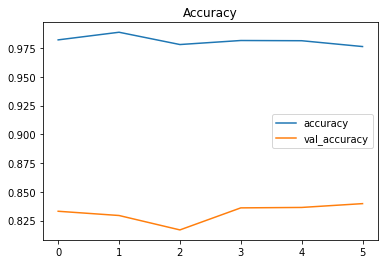

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

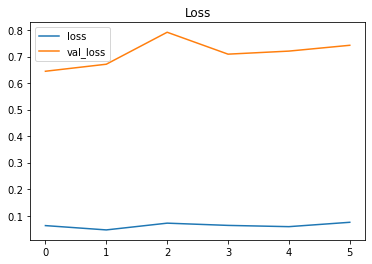

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.28791
Test Accuracy: 90.20%


In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')


The first 5 predictions: ['roller derby', 'arm wrestling', 'cheerleading', 'polo', 'snow boarding']


In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      0.60      0.75         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       0.83      1.00      0.91         5
         balance beam       1.00      0.80      0.89         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      0.60      0.75         5
           basketball       1.00      1.00      1.00         5
       baton twirling       1.00      0.80      0.89         5
            bike polo       1.00      0.80      0.89         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.80      0.89         5
              bobsled       1.00      1.00      1.00         5
              bowling       1.00      0.80      0.89  

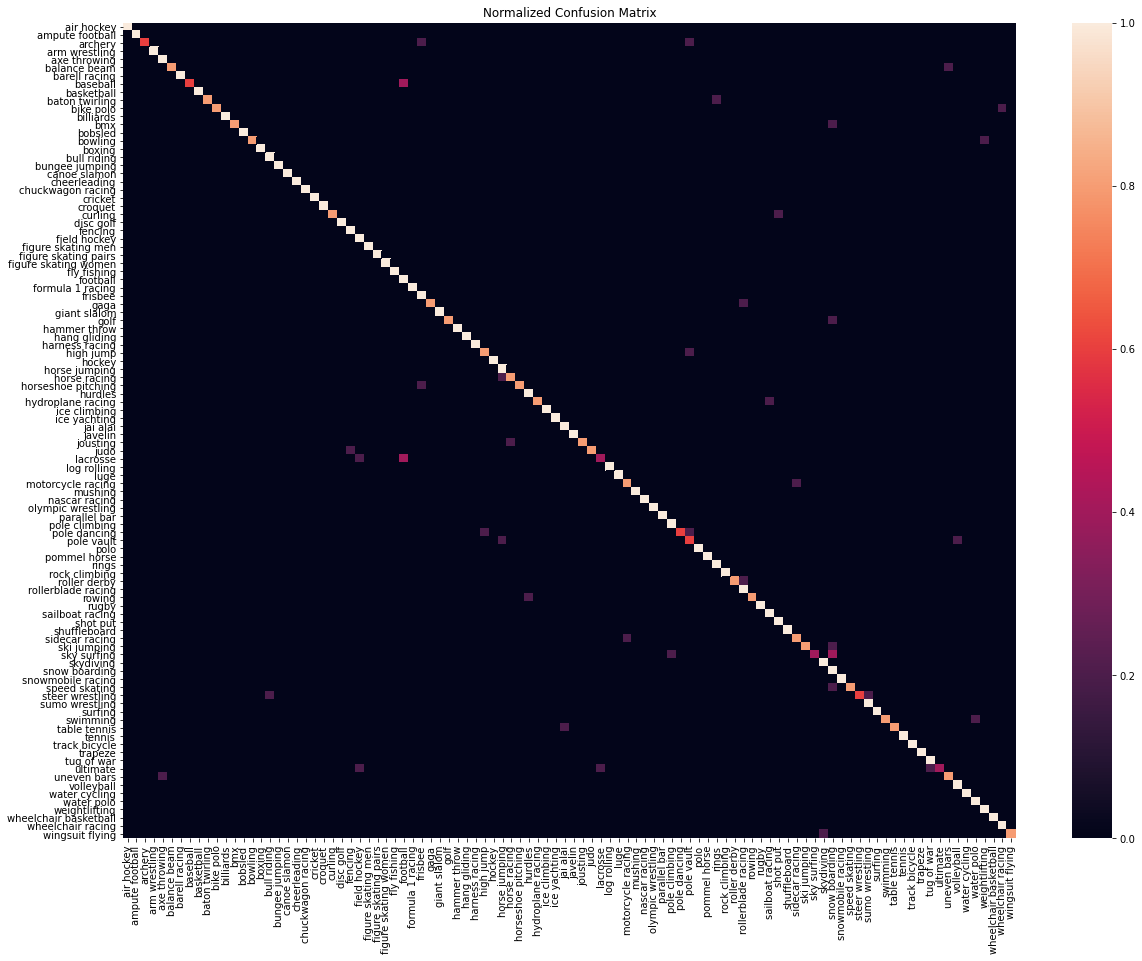

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

# **Examples of prediction**

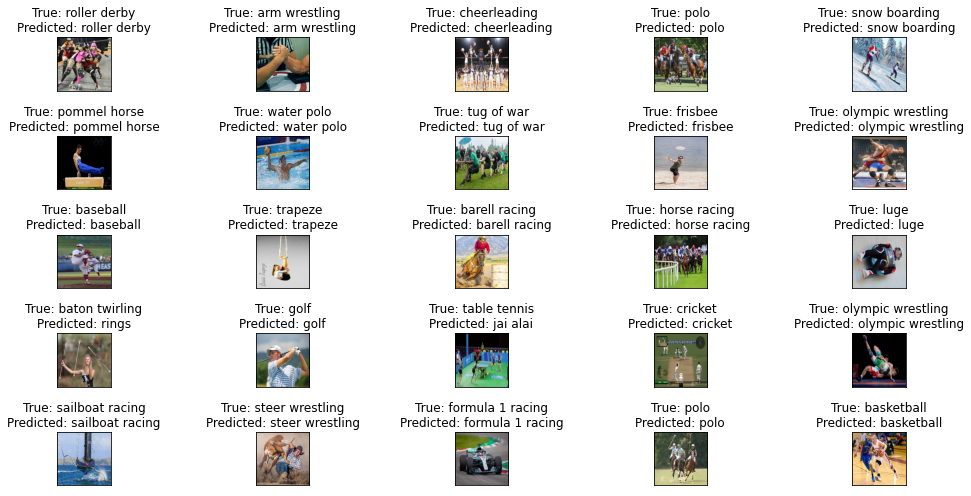

In [ ]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=5, ncols=5 , figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
#model.save('my_model.h5') 

C:\Users\Jaswanth\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
